In [26]:
import tensorflow as tf
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras import Model
from tensorflow.keras.experimental import LinearModel

In [27]:
%config Completer.use_jedi = False

In [28]:
# Uncomment the following to disable GPU
tf.config.set_visible_devices([], 'GPU')
print(tf.config.get_visible_devices())
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
1 Physical GPUs, 0 Logical GPUs


# Import parquet data

In [29]:
ds = pq.ParquetDataset("/var/log/fancontrol/featurelog")
ptable = ds.read().to_pandas()

In [30]:
# Get rid of outliers in power feture
def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)
power = ptable['power'].apply(lambda a: clamp(a[0], 0.0, 99.0))

In [31]:
import seaborn as sns
import statistics

In [32]:
cpu_idle = ptable['mean_cpu_idle'] = ptable['cpu_idle'].apply(statistics.mean)

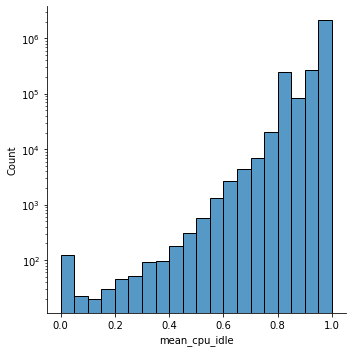

In [33]:
sns.displot(ptable['mean_cpu_idle'], binwidth=0.05, log=True)

In [47]:
def group_idle(val):
    gval = 20.0 * val
    try:
        return int(gval)
    except:
        return 0

ptable['ig'] = ptable['mean_cpu_idle'].apply(group_idle)

In [48]:
groups = [ptable[ptable['ig']==i] for i in range(0,20)]

In [49]:
[len(groups[i]) for i in range(0,20)]

[131,
 23,
 19,
 31,
 45,
 51,
 93,
 96,
 182,
 309,
 579,
 1338,
 2655,
 4420,
 6910,
 20410,
 243811,
 86874,
 265432,
 1857690]

In [53]:
!pip install sklearn

  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 22.2 MB 1.3 MB/s            
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1309 sha256=93055a90af7746601424cc9c3559c3431f2ab6fb7f67f280fa88b45d20d57557
  Stored in directory: /home/danielk/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn
Note: you may need to restart the kernel to use updated packages.


In [56]:
from sklearn.utils import resample
g = [resample(groups[i], replace=True, n_samples=20410) for i in range(0, 20)]

In [57]:
balanced = pd.concat(g)

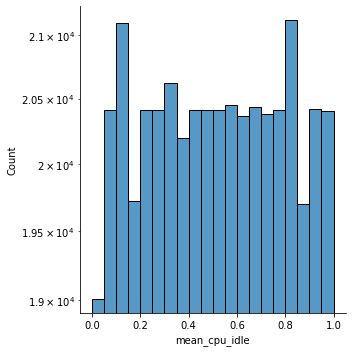

In [58]:
sns.displot(balanced['mean_cpu_idle'], binwidth=0.05, log=True)

In [59]:
ptable = balanced

In [60]:
def feature_names():
    l = list(ptable.columns.values)
    l.remove('label')
    return l

def generator_types():
    return ({k: tf.float32 for k in feature_names()}, tf.float32)

def dim(val):
    return 1 if isinstance(val, float) or isinstance(val, int) else len(val)

def generator_shapes():
    _, row = next(ptable.iterrows())
    shapes = {k: (1, dim(row[k])) for k in feature_names()}
    return tuple([shapes, (1,)])

print(feature_names())
print(generator_types())
print(generator_shapes())

['timestamp', 'cpuinfo', 'profile', 'cpu_idle', 'cpu_user', 'cpu_system', 'cpu_nice', 'power_constraints', 'power', 'temp', 'fan_rpm', 'year', 'month', 'day', 'mean_cpu_idle', 'ig']
({'timestamp': tf.float32, 'cpuinfo': tf.float32, 'profile': tf.float32, 'cpu_idle': tf.float32, 'cpu_user': tf.float32, 'cpu_system': tf.float32, 'cpu_nice': tf.float32, 'power_constraints': tf.float32, 'power': tf.float32, 'temp': tf.float32, 'fan_rpm': tf.float32, 'year': tf.float32, 'month': tf.float32, 'day': tf.float32, 'mean_cpu_idle': tf.float32, 'ig': tf.float32}, tf.float32)
({'timestamp': (1, 1), 'cpuinfo': (1, 8), 'profile': (1, 1), 'cpu_idle': (1, 8), 'cpu_user': (1, 8), 'cpu_system': (1, 8), 'cpu_nice': (1, 8), 'power_constraints': (1, 2), 'power': (1, 1), 'temp': (1, 10), 'fan_rpm': (1, 1), 'year': (1, 1), 'month': (1, 1), 'day': (1, 1), 'mean_cpu_idle': (1, 1), 'ig': (1, 1)}, (1,))


In [61]:
def convert(key, value):
    if isinstance(value, float) or isinstance(value, int):
        return tf.reshape(tf.convert_to_tensor(value, tf.float32, name=key), (1, 1))
    return tf.reshape(tf.convert_to_tensor(value, tf.float32, name=key), (1, dim(value)))

def generator():
    for index, row in ptable.iterrows():
        f = {k: convert(k, row[k]) for k in feature_names()}
        l = tf.convert_to_tensor(list([float(row['label'])]), tf.float32, name='label')
        yield f, l

In [62]:
all = tf.data.Dataset.from_generator(generator, output_types=generator_types(), output_shapes=generator_shapes()) \
    .shuffle(10, reshuffle_each_iteration=False)
n = next(all.batch(2).as_numpy_iterator())
print(n)

({'timestamp': array([[[1.6377565e+09]],

       [[1.6378006e+09]]], dtype=float32), 'cpuinfo': array([[[2626.457, 2618.725, 2626.186, 2626.184, 2626.186, 2626.184,
         2626.186, 2626.078]],

       [[3632.358, 3643.844, 3348.178, 3644.106, 3632.358, 3643.868,
         3348.178, 3644.106]]], dtype=float32), 'profile': array([[[1.]],

       [[1.]]], dtype=float32), 'cpu_idle': array([[[0.03846154, 0.12      , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        ]]], dtype=float32), 'cpu_user': array([[[0.9230769 , 0.6       , 1.        , 0.96153843, 1.        ,
         1.        , 0.9230769 , 0.84615386]],

       [[0.8666667 , 0.8666667 , 0.93333334, 0.93333334, 0.8666667 ,
         0.79310346, 0.9       , 0.93333334]]], dtype=float32), 'cpu_system': array([[[0.03846154, 0.28      , 0.        , 0.03846154, 0.        ,
         0.        ,

In [63]:
tf.shape(n[0]['temp']).numpy()

array([ 2,  1, 10], dtype=int32)

In [64]:
tf.shape(n[1]).numpy()

array([2, 1], dtype=int32)

In [65]:
def is_test(x, y):
    return x % 4 == 0
def is_train(x, y):
    return not is_test(x, y)
recover = lambda x,y: y
test_dataset = all.enumerate() \
                    .filter(is_test) \
                    .map(recover)

train_dataset = all.enumerate() \
                    .filter(is_train) \
                    .map(recover)

# Lets build a simple model

In [66]:
from tensorflow.keras import layers
from tensorflow import keras

In [88]:
temp_input = Input(shape=(10,), name="temp")
cpu_idle_input = Input(shape=(8,), name="cpu_idle")
power_input = Input(shape=(1,), name="power")
fan_input = Input(shape=(1,), name="fan_rpm")
all_input = [power_input , temp_input] #, cpu_idle_input, fan_input]

In [89]:
x = layers.concatenate(all_input)

In [90]:
fanlevel_output = Dense(1, name="level")(x)

In [94]:
linear_model=keras.Model(inputs=all_input, outputs=[fanlevel_output])
optimizer = keras.optimizers.Adam(learning_rate=0.001)
linear_model.compile(optimizer=optimizer, loss='msle')

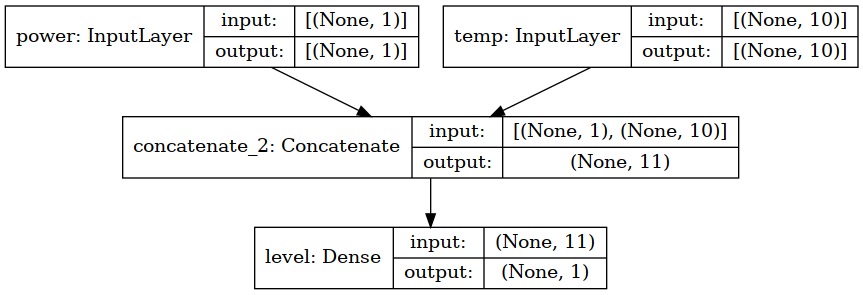

In [95]:
keras.utils.plot_model(linear_model, "multi_input_and_output_model.png", show_shapes=True)

In [96]:
linear_model.fit(train_dataset, epochs=1, batch_size=64)

/home/danielk/.pyenv/versions/3.6.11/envs/smart-fancontrol/lib/python3.6/site-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['timestamp', 'cpuinfo', 'profile', 'cpu_idle', 'cpu_user', 'cpu_system', 'cpu_nice', 'power_constraints', 'fan_rpm', 'year', 'month', 'day', 'mean_cpu_idle', 'ig'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


306150/306150 [==============================] - 1419s 5ms/step - loss: 0.0658


In [113]:
for layer in linear_model.layers:
    if layer.name == 'level':
        print("weights: " + str(layer.get_weights()[0]))
        print("bias: " + str(layer.get_weights()[1]))

weights: [[-0.00143334]
 [ 0.54910326]
 [-0.00203671]
 [-0.00422742]
 [-0.00214741]
 [-0.00148244]
 [ 0.0047739 ]
 [-0.00961473]
 [ 0.3152248 ]
 [-0.26774046]
 [-0.54554415]]
bias: [-0.648314]


In [131]:
# extract_sensors_tensor_names output
{'temp': ['temp1.temp1_input', 'Core 0.temp2_input', 'Core 1.temp3_input', 'Core 2.temp4_input', 'Core 3.temp5_input', 'Package id 0.temp1_input', 'temp1.temp1_input', 'Composite.temp1_input', 'Sensor 1.temp2_input', 'CPU.temp1_input'], 'fan_rpm': ['Fan1.fan1_input']}

{'temp': ['temp1.temp1_input',
  'Core 0.temp2_input',
  'Core 1.temp3_input',
  'Core 2.temp4_input',
  'Core 3.temp5_input',
  'Package id 0.temp1_input',
  'temp1.temp1_input',
  'Composite.temp1_input',
  'Sensor 1.temp2_input',
  'CPU.temp1_input'],
 'fan_rpm': ['Fan1.fan1_input']}

In [114]:
n[0]['temp']

array([[[65.  , 63.  , 66.  , 65.  , 64.  , 66.  , 48.  , 50.85, 50.85,
         65.  ]],

       [[66.  , 79.  , 80.  , 76.  , 80.  , 80.  , 54.  , 55.85, 55.85,
         66.  ]]], dtype=float32)

It appears that these four are the only ones that matter
'Core 0.temp2_input' 'CPU.temp1_input' 'Composite.temp1_input', 'Sensor 1.temp2_input' for the linear model

Let's save the model and then evaluate it on the test set

In [115]:
linear_model.save("clean_train")

INFO:tensorflow:Assets written to: clean_train/assets


In [132]:
print("Evaluate on test data")
results = linear_model.evaluate(test_dataset, batch_size=1024)
print("test loss, test acc:", results)

Evaluate on test data
102050/102050 [==============================] - 789s 8ms/step - loss: 0.0913
test loss, test acc: 0.09127047657966614


The loss a bit higher than the training loss. So we probably overfit that data.

But that's ok. Right now we're just trying to see if we can learn anything. i.e. there are some correlations to be had in the data.

In this setup we are really just trying to learn the heuristic and since that is non-linear we'll alway be a bit off with this linear model.

In [135]:
f = {'power': tf.reshape(tf.constant(5.0), (1,1)),
     'temp': tf.reshape(tf.constant([39., 33., 34., 34., 34., 38., 36., 42.85, 42.85, 39.]), (1, 10))}
linear_model.predict(f)

array([[1.018949]], dtype=float32)

In [136]:
model = tf.keras.models.load_model('/home/danielk/code/smart-fancontrol/features/clean_train')

In [137]:
model.predict(f)

array([[1.018949]], dtype=float32)

In [139]:
f = {'power': tf.reshape(tf.constant(5.0), (1,1)),
     'temp': tf.reshape(tf.constant([79., 33., 34., 34., 34., 38., 36., 92.85, 92.85, 69.]), (1, 10))}
model.predict(f)

array([[8.990961]], dtype=float32)

In [140]:
f = {'power': tf.reshape(tf.constant(5.0), (1,1)),
     'temp': tf.reshape(tf.constant([79., 33., 34., 34., 34., 38., 36., 92.85, 92.85, 89.]), (1, 10))}
model.predict(f)

array([[-1.9199204]], dtype=float32)

Some of what has been learned is bunk :) Higher temps should not make the fan go slower!